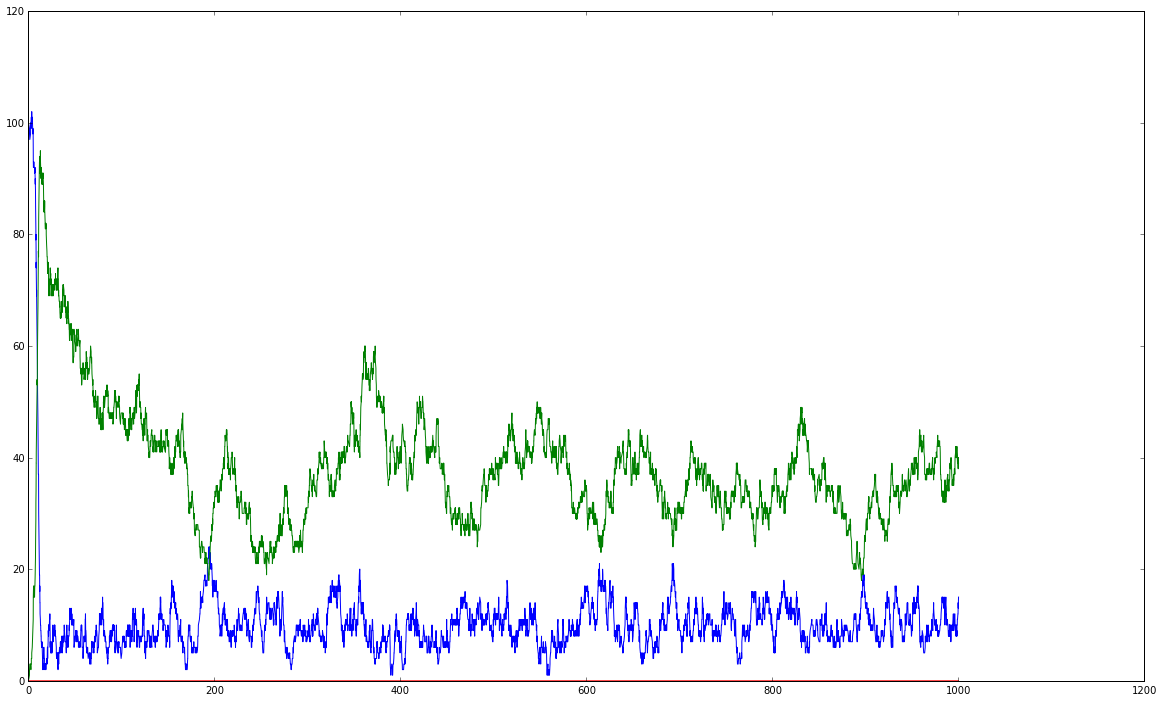

In [23]:
#coding=utf-8

from sympy import symbols
import numpy as np
import matplotlib.pyplot as pl

import gillespie
from gillespie import integrate
from gillespie import cython_propensity_function
reload(gillespie)

%matplotlib inline

X, Y, Z = symbols('X Y Z', integer=True)
B, l, mu, nu = symbols('β λ μ ν', real=True)

x = [X, Y, Z]

T = [
    {X: -1, Y: 1},
    {X: -1, Y: 1},
    {X:  1},
    {Y: -1}
]

prop = [
  B*X*Y,
  nu*X,
  l,
  mu*Y
]

ics = {
  X: 100,
  Y: 0
}

parm = {
  B: 0.005,
  l: 2,
  mu: 0.05,
  nu: 0.01
}

y = list(integrate(x, T, prop, parm, ics, 1000))
t, y1, y2, y3 = np.transpose(y)

pl.figure(figsize=(20,12))
ax = pl.plot(t, y1, t, y2, t, y3)

In [ ]:

print x

[np.asarray(ics.get(xi,0)) for xi in x]


In [ ]:
np.array([100])+np.array([1,2])

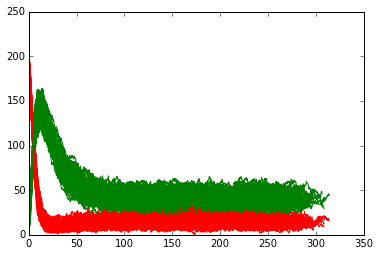

In [49]:
import numpy as np
import theano
import theano.tensor as tt

from theano.tensor.shared_randomstreams import RandomStreams

def go():
    
    X, Y = map(tt.dvector, "XY")
    B, l, mu, nu = map(tt.dscalar, ['β', 'λ', 'μ', 'ν'])
    reps = 200
    var_v  = [X, Y]
    parm_v = [B, l, mu, nu]
    
    rng = RandomStreams(seed=233) #todo: makes sure it runs on GPU
    r_u = rng.uniform((1,reps))
    
    t = [
        {X: -1, Y: 1},
        {X: -1, Y: 1},
        {X:  1},
        {Y: -1}
    ]
    
    T_ = np.asarray([
        [-1, 1],
        [-1, 1],
        [ 1, 0],
        [ 0,-1]
    ])

    prop_v = [B*X*Y, nu*X, l, mu*Y]
    prop_t = sum(prop_v)
    prob_v = [p/prop_t for p in prop_v]
    #v = tt.stack(prob_v)
    v = tt.stack(prob_v).reshape((4,reps)).T #This happens because of variables as dvectors (rxns, reps)
    
    prb_f = theano.function(var_v+parm_v, v)
    
    tau_f = theano.function(var_v+parm_v, (1/prop_t)*tt.log(1/r_u))
    
    ran_f = theano.function(var_v+parm_v, rng.multinomial(n=1, pvals=v))
    
    ics = [
        np.asarray([200]*reps),
        np.asarray([2]*reps)
    ]
    
    parm = [0.001, 2, 0.05, 0.1]
    x = ics
    interval = 2000
    time = np.zeros(shape=(1,reps))
    out = np.zeros(shape=(reps, interval, len(var_v)+1)) #(rep, time, vars+time)
    
    for idx in range(interval):
    
        #prop_i = prb_f(*args)
        #print prop_i

        #print prop_i
        #print ran_i
        args = [x[0],x[1]]+parm
        time += tau_f(*args)

        ran_i = ran_f(*args)
        incr = np.dot(ran_i, T_).T
        #print incr.T

        x = np.asarray(x)+incr
        out[:,idx,:] = np.concatenate((time, x)).T

    #r[0,:,1,:] = x[0]
    #r[0,:,:,1] = x[1]
    #print r.shape
    #print r[0]
    #print out[0,:,1:3]
    #print out[0,:,0:1]
    for q in range(reps):
        pl.plot(out[q,:,0:1], out[q,:,1], "r-", out[q,:,0:1], out[q,:,2], "g-")
    
go()

In [ ]:
import sympy
x, y, z = symbols('x y z')
sympy.simplify(x*2 + 2*x - 4)

In [ ]:
import theano.tensor as T
x = T.dvector('x')
y = T.dmatrix('y')

fn = theano.function([x,y], 2*T.dot(x,y))

x_, y_ = np.array([1,2,3]), np.array([
        [3,2,1,5,1,7],
        [1,2,4,6,1,8],
        [4,5,6,7,1,1]
    ])

fn(x_,y_)

In [ ]:
np.array([1,3,4]).T

In [ ]:
rng = RandomStreams(seed=234)

Z = tt.dmatrix('Z')
fn_ = theano.function([Z], rng.multinomial(n=1, pvals=Z))

In [ ]:
S = np.zeros(shape=(2,2), dtype=np.float32)

z = np.asarray(map(lambda i: fn_(np.array([[0.5,0.5],[0.1,0.9]])), range(100)), dtype=np.float32)

print np.sum(z, axis=0)/np.sum(z, axis=(0,2), keepdims=True)


In [ ]:
sum([1,2])